In [1]:
from functions import *
from IPython.display import Audio, display

## Models
### Models inspired by `hvqvae_model_2023_03_05_v4.h5` (for hyperparameters and epochs)
#### use_argmax=False
* `estm_model_2023_03_15_v0.h5`: 32 latent dim, 1024 codebook, $\beta=1.25$, 50 epochs
* `estm_model_2023_03_15_v1.h5`: 32 latent dim, 1024 codebook, $\beta=1.25$, 43 epochs (early stopping)
* `estm_model_2023_03_15_v2.h5`: 32 latent dim, 1024 codebook, $\beta=1.25$, 47 epochs
* `estm_model_2023_03_21_v0.h5`: 16 latent dim, 1024 codebook, $\beta=1.25$, 28 epochs (infinite loss - do not use)
* `estm_model_2023_03_21_v1.h5`: 16 latent dim, 1024 codebook, $\beta=1.25$, 28 epochs (infinite loss - do not use)
* `estm_model_2023_03_21_v2.h5`: 20 latent dim, 1024 codebook, $\beta=1.25$, 35 epochs
---
#### use_argmax=True
* `estm_model_2023_03_21_v3.h5`: 20 latent dim, 1024 codebook, $\beta=1.25$, 46 epochs

### Grid:
#### $\beta\in\{0.25, 0.5, 0.75, 1, 1.25, 1.5\}$, `latent_dim`$\in\{20, 24\}$
* `latent_dim=20`:
    * $\beta=0.25$: `estm_model_2023_03_21_v4.h5`
    * $\beta=0.5$: `estm_model_2023_03_21_v5.h5`
    * $\beta=0.75$: `estm_model_2023_03_21_v6.h5`
    * $\beta=1$: `estm_model_2023_03_21_v7.h5`
    * $\beta=1.25$: `estm_model_2023_03_21_v8.h5`
    * $\beta=1.5$: `estm_model_2023_03_21_v9.h5`
* `latent_dim=24`:
    * $\beta=0.25$: `estm_model_2023_03_21_v10.h5`
    * $\beta=0.5$: `estm_model_2023_03_21_v11.h5`
    * $\beta=0.75$: `estm_model_2023_03_21_v12.h5`
    * $\beta=1$: `estm_model_2023_03_21_v13.h5`
    * $\beta=1.25$: `estm_model_2023_03_21_v14.h5`
    * $\beta=1.5$: `estm_model_2023_03_21_v15.h5`
---
## Testing: training set, test set, auxillary set
* Reconstruction error
* True emotion accuracy
* Predicted emotion accuracy
* Measure how much influence emotion embedding has (how? go back to MIDI-VAE)
    * Generate with same content input, different style inputs and measure difference against content input

In [7]:
n_segs  = 10095
seg_len = 222264

In [8]:
df = pd.read_csv('data\\deam_split.csv')
songs = df['song_id']
test = df['test']
val = df['validation']
qs = df[['Q1', 'Q2', 'Q3', 'Q4']].to_numpy()

In [9]:
df = pd.read_csv('data\\deam_predictions.csv')
df = df.set_index('song_id')

In [5]:
max_pct_zero = 0.5
paths = [f'data\\DEAM_standard_10s\\{song}-*.wav' for song in songs]
use_argmax = True

X_train = np.zeros((n_segs, seg_len, 1))
X_test  = np.zeros((n_segs, seg_len, 1))

S_train = np.zeros((n_segs, 2, 4))
S_test  = np.zeros((n_segs, 2, 4))

id_train = []
id_test  = []

j_train = 0; j_test = 0
for i in tqdm(range(len(paths))):
    files = glob(paths[i])
    for file in files:
        seg, sr = lb.load(file)
        n = seg.shape[0]
        if (seg == 0).sum()/n <= max_pct_zero:
            if test[i] == 1:
                X_test[j_test, :, 0] = seg
                style_embed = df.loc[style].to_numpy()
                if use_argmax:
                    temp = np.zeros(4)
                    temp[np.argmax(style_embed)] = 1
                    style_embed = temp
                S_test[j_test, 0, :] = style_embed # predicted
                S_test[j_test, 1, :] = qs[i, :] # true
                id_test.append(file)
                j_test += 1
            else:
                X_train[j_train, :, 0] = seg
                style_embed = df.loc[style].to_numpy()
                if use_argmax:
                    temp = np.zeros(4)
                    temp[np.argmax(style_embed)] = 1
                    style_embed = temp
                S_train[j_train, 0, :] = style_embed # predicted
                S_train[j_train, 1, :] = qs[i, :] # true
                id_train.append(file)
                j_train += 1
X_train = X_train[:j_train, :, :]
X_test  = X_test[:j_test, :, :]

S_train = S_train[:j_train, :, :]
S_test  = S_test[:j_test, :, :]

id_train = np.array(id_train)[:j_train]
id_test  = np.array(id_test)[:j_test]

  0%|          | 0/1802 [00:00<?, ?it/s]

In [10]:
X_train.shape, X_test.shape

NameError: name 'X_train' is not defined

In [7]:
S_train.shape, S_test.shape

((6680, 2, 4), (1645, 2, 4))

In [11]:
lrelu = keras.layers.LeakyReLU(alpha=0.01)

In [12]:
def get_encoder(latent_dim):
    encoder_inputs = keras.Input(shape=(seg_len, 1))
    level_rate = [3, 5, 7]
    levels = []
    for rate in level_rate:
        level = encoder_inputs
        for i in range(rate):
            level = Conv1D(
                latent_dim, 
                3, 
                strides=2, 
                activation=lrelu
            )(level)
        levels.append(level)
    return keras.Model(encoder_inputs, levels, name='encoder')

In [13]:
def get_decoder(latent_dim):
    intermediate_steps = 27782
    intermediate_ch = int(3*latent_dim/2)
    latent_inputs = keras.Input(shape=(intermediate_steps, intermediate_ch))
    ch = int(intermediate_ch/2)
    x = Conv1DTranspose(ch, 3, strides=2, activation=lrelu)(latent_inputs)
    ch = int(ch/2)
    x = Conv1DTranspose(ch, 3, strides=2, activation=lrelu)(x)
    decoder_outputs = Conv1DTranspose(1, 3, strides=2, activation=lrelu, output_padding=1)(x)
    return keras.Model(latent_inputs, decoder_outputs, name='decoder')

In [11]:
# shapes = [(27782, 32), (6944, 32), (1735, 32)]
# inputs = [keras.Input(shape=shape) for shape in shapes]

# output1 = Conv1DTranspose(16, 3, activation=lrelu, padding='same')(inputs[0])
# print(output1.shape)

# output2 = Conv1DTranspose(32, 3, strides=2, activation=lrelu, output_padding=1)(inputs[1])
# output2 = Conv1DTranspose(16, 3, strides=2, activation=lrelu, output_padding=1)(output2)
# print(output2.shape)

# output3 = Conv1DTranspose(32, 3, strides=2, activation=lrelu)(inputs[2])
# output3 = Conv1DTranspose(32, 3, strides=2, activation=lrelu, output_padding=1)(output3)
# output3 = Conv1DTranspose(32, 3, strides=2, activation=lrelu, output_padding=1)(output3)
# output3 = Conv1DTranspose(16, 3, strides=2, activation=lrelu, output_padding=1)(output3)
# print(output3.shape)

# output = layers.Concatenate()([output1, output2, output3])
# output.shape

In [12]:
# output = Conv1DTranspose(3, 3, strides=2, activation=lrelu)(output)
# output = Conv1DTranspose(3, 3, strides=2, activation=lrelu)(output)
# output = Conv1DTranspose(1, 3, strides=2, activation=lrelu, output_padding=1)(output)
# output.shape

In [13]:
# encoder_inputs = keras.Input(shape=(seg_len, 1))
# level_rate = [3, 5, 7]
# levels = []
# for rate in level_rate:
#     level = encoder_inputs
#     for i in range(rate):
#         level = Conv1D(latent_dim, 3, strides=2, activation=lrelu, padding='same')(level)
#     levels.append(level)
# model = keras.Model(encoder_inputs, levels)
# model.summary()

# ch = latent_dim*4
# x = GRU(ch, return_sequences=True)(encoder_inputs)
# ch = latent_dim*2
# x = GRU(ch, return_sequences=True)(x)
# encoder_outputs = GRU(latent_dim, return_sequences=True)(x)
# encoder_outputs.shape

### Build VQ-VAE

In [14]:
def get_vqvae(latent_dim, num_embeddings, beta=0.25):
    vq_layers = [
        VectorQuantizer(num_embeddings, latent_dim, beta=beta, name=f'embeddings_vqvae_{i}') for i in range(3)
    ]
    encoder = get_encoder(latent_dim)
    decoder = get_decoder(latent_dim + 4)
    content_input = keras.Input(shape=(seg_len, 1))
    style_input = keras.Input(shape=(1, 4))
    
    encoder_outputs = encoder(content_input)
    
    quantized_latents = [
        vq_layer(encoder_output) for vq_layer, encoder_output in zip(vq_layers, encoder_outputs)
    ]
    
    intermediate = int((latent_dim + 4)/2)
    
    bottom = quantized_latents[0]
    bottom_style = tf.tile(style_input, (1, bottom.shape[1], 1))
    bottom = layers.Concatenate(axis=-1)([bottom, bottom_style])
    bottom = Conv1DTranspose(
        intermediate, 3, activation=lrelu, padding='same'
    )(bottom)
    
    middle = quantized_latents[1]
    middle_style = tf.tile(style_input, (1, middle.shape[1], 1))
    middle = layers.Concatenate(axis=-1)([middle, middle_style])
    middle = Conv1DTranspose(
        latent_dim, 3, strides=2, activation=lrelu, output_padding=1
    )(middle)
    middle = Conv1DTranspose(
        intermediate, 3, strides=2, activation=lrelu, output_padding=1
    )(middle)
    
    top    = quantized_latents[2]
    top_style = tf.tile(style_input, (1, top.shape[1], 1))
    top    = layers.Concatenate(axis=-1)([top, top_style])
    top    = Conv1DTranspose(
        latent_dim, 3, strides=2, activation=lrelu
    )(top)
    top    = Conv1DTranspose(
        latent_dim, 3, strides=2, activation=lrelu, output_padding=1
    )(top)
    top    = Conv1DTranspose(
        latent_dim, 3, strides=2, activation=lrelu, output_padding=1
    )(top)
    top    = Conv1DTranspose(
        intermediate, 3, strides=2, activation=lrelu, output_padding=1
    )(top)
    
    intermediate_latents = layers.Concatenate()([bottom, middle, top])
    reconstructions = decoder(intermediate_latents)
    return keras.Model([content_input, style_input], reconstructions, name='vq_vae')

In [15]:
train_variance = 0.04383824434697565

In [16]:
model_list = [
    'estm_v1_models/estm_model_2023_03_21_v4.h5'
]
models = {}
for model in model_list:
    trainer = ESTMTrainer(
        train_variance, 
        get_vqvae,
        latent_dim=16,
        num_embeddings=1024,
        beta=1.25
    )
    trainer.build([(None, seg_len, 1), (None, 1, 4)])
    trainer.load_weights(model)
    models[model] = trainer

### Experiments

In [24]:
train_test = 'train'
use_argmax = True
num_exp = 5
exp_df = pd.read_csv(f'data/estm_{train_test}_exp.csv')
exp_df = exp_df.sample(num_exp)

In [25]:
X_exp = np.zeros((num_exp, seg_len, 1))
S_audio = np.zeros((num_exp, seg_len, 1))
S_exp = np.zeros((num_exp, 1, 4))

In [26]:
for j, i in enumerate(exp_df.index):
    content, style = exp_df.loc[i]
    content = f'data\\DEAM_standard_10s\\{content}'
    style = f'data\\DEAM_standard_10s\\{style}'
    seg, sr = lb.load(content)
    X_exp[j, :, 0] = seg
    seg, sr = lb.load(style)
    S_audio[j, :, 0] = seg
    style_embed = df.loc[style].to_numpy()
    if use_argmax:
        temp = np.zeros(4)
        temp[np.argmax(style_embed)] = 1
        style_embed = temp
    S_exp[j, 0, :] = style_embed

In [27]:
rate=22050
for j, i in enumerate(exp_df.index):
    content, style = exp_df.loc[i]
    print(f'Content: {content}')
    display(Audio(data=X_exp[j, :, 0], rate=rate))
    print(f'Style: {style}')
    display(Audio(data=S_audio[j, :, 0], rate=rate))
    for model in model_list:
        print(f'{model} transformation:')
        out = models[model].predict(
            [
                X_exp[j, :, :].reshape((1, seg_len, 1)),
                S_exp[j, :, :].reshape((1, 1, 4))
            ],
        verbose=0)
        display(Audio(data=out[0, :, 0],rate=rate))
    print('---------------------------------------')

Content: 1344-1.wav


Style: 420-0.wav


estm_models/estm_model_2023_03_21_v3.h5 transformation:


---------------------------------------
Content: 836-1.wav


Style: 1653-2.wav


estm_models/estm_model_2023_03_21_v3.h5 transformation:


---------------------------------------
Content: 358-3.wav


Style: 367-2.wav


estm_models/estm_model_2023_03_21_v3.h5 transformation:


---------------------------------------
Content: 841-1.wav


Style: 1003-0.wav


estm_models/estm_model_2023_03_21_v3.h5 transformation:


---------------------------------------
Content: 1204-4.wav


Style: 448-1.wav


estm_models/estm_model_2023_03_21_v3.h5 transformation:


---------------------------------------


### Plot training history and testing results

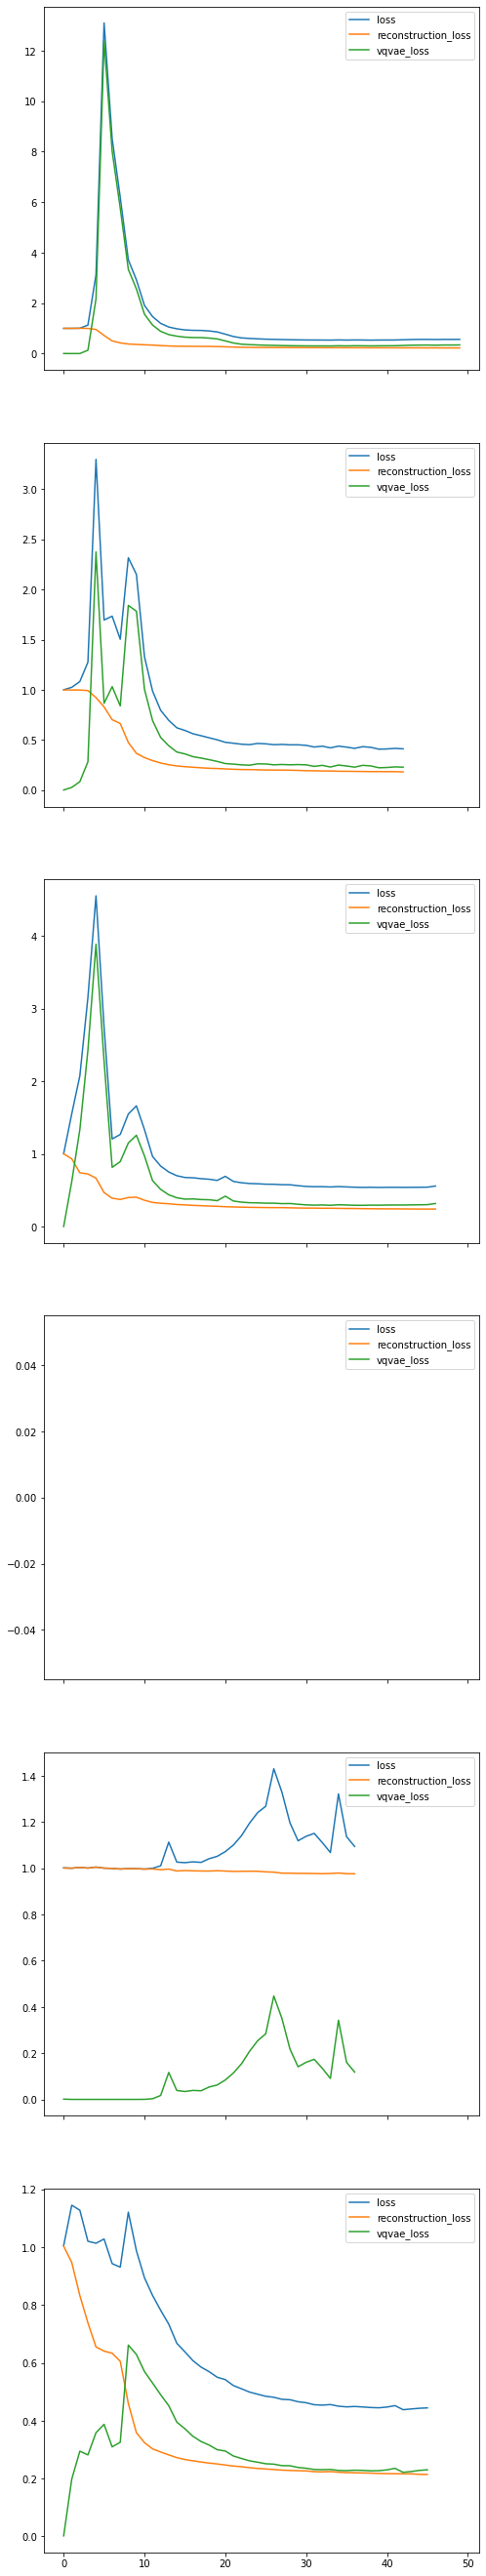

In [28]:
hist_paths = glob('estm_models/*.csv')
histories = [pd.read_csv(path) for path in hist_paths]
losses = [history.loc[:, history.columns.str.endswith('loss')] for history in histories]
fig, ax = plt.subplots(nrows=len(losses), ncols=1, sharex=True, figsize=(8, 8*len(losses)))
for i, loss in enumerate(losses):
    for col in loss.columns:
        ax[i].plot(loss.index, loss[col])
    ax[i].legend(loss.columns)
plt.show()

In [21]:
modelkey = {
    'estm_model_2023_03_21_v4.h5': (16, 0.25),
    'estm_model_2023_03_21_v5.h5': (16, 0.5),
    'estm_model_2023_03_21_v6.h5': (16, 0.75),
    'estm_model_2023_03_21_v7.h5': (16, 1.),
    'estm_model_2023_03_21_v8.h5': (16, 1.25),
    'estm_model_2023_03_21_v9.h5': (16, 1.5),
    'estm_model_2023_03_21_v10.h5': (20, 0.25),
    'estm_model_2023_03_21_v10.h5': (20, 0.5),
    'estm_model_2023_03_21_v11.h5': (20, 0.75),
    'estm_model_2023_03_21_v12.h5': (20, 1.),
    'estm_model_2023_03_21_v13.h5': (20, 1.25),
    'estm_model_2023_03_21_v14.h5': (20, 1.5)
}
model_df = pd.DataFrame(modelkey.values(), columns=['latent_dim', 'beta'], index=modelkey.keys())

In [67]:
testing_df = pd.read_csv('estm_test_results.csv')
testing_df['model'] = [name[31:] for name in testing_df['model']]
testing_df = testing_df.set_index('model')
testing_df = testing_df.join(model_df)
testing_df['latent_dim'] = testing_df['latent_dim'] + 4

In [66]:
latent_20 = testing_df.loc[testing_df['latent_dim'] == 20].sort_values('beta')
latent_24 = testing_df.loc[testing_df['latent_dim'] == 24].sort_values('beta')
cols = testing_df.drop(columns=['latent_dim', 'beta']).columns
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10, 10), sharey=True)
ax[0, 0].set_ylabel('train')
ax[1, 0].set_ylabel('test')
ax[0, 0].set_title('latent_dim=20')
ax[0, 1].set_title('latent_dim=24')
ax[0, 0].set_xlabel(r'$\beta$')
ax[1, 0].set_xlabel(r'$\beta$')
ax[0, 1].set_xlabel(r'$\beta$')
ax[1, 1].set_xlabel(r'$\beta$')
for i, col in enumerate(cols.drop(['train_content_dev', 'test_content_dev'])):
    if col.startswith('train'):
        ax[0, 0].plot(latent_20['beta'], latent_20[col])
        ax[0, 1].plot(latent_24['beta'], latent_24[col])
    else:
        ax[1, 0].plot(latent_20['beta'], latent_20[col])
        ax[1, 1].plot(latent_24['beta'], latent_24[col])
ax[0, 1].legend(['Reconst. loss', 'PEA', 'AEA'])
plt.tight_layout()

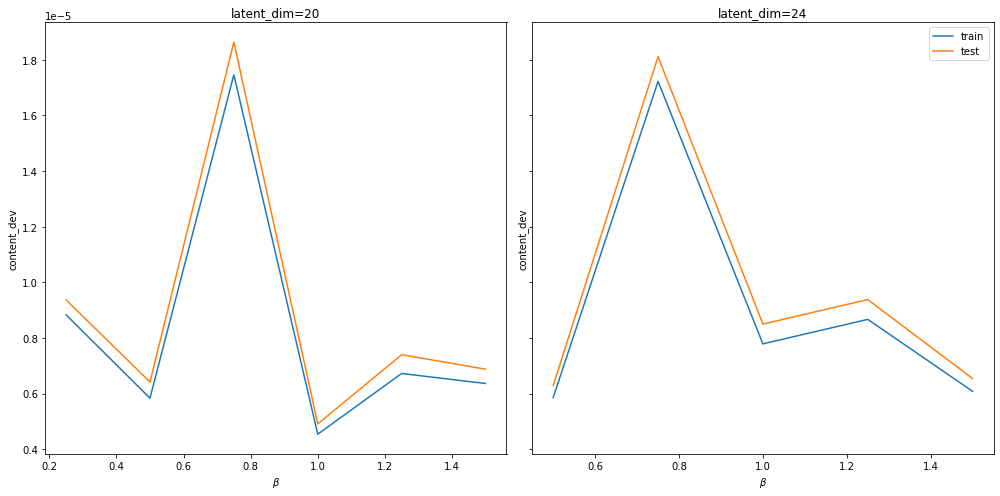

In [68]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(14, 7), sharey=True)
ax[0].set_ylabel('content_dev')
ax[1].set_ylabel('content_dev')
ax[0].set_title('latent_dim=20')
ax[1].set_title('latent_dim=24')
ax[0].set_xlabel(r'$\beta$')
ax[1].set_xlabel(r'$\beta$')
for i, col in enumerate(cols):
    if col.endswith('content_dev'):
        ax[0].plot(latent_20['beta'], latent_20[col])
        ax[1].plot(latent_24['beta'], latent_24[col])
ax[1].legend(['train', 'test'])
plt.tight_layout()